<a href="https://colab.research.google.com/github/Harsh18999/Machine-Learning-Projects/blob/main/Bagpack%20Price%20Prediction%20(Kaggle%20Competition)/%20Bagpack_Price_Prediction_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 24.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
bigframes 1.36.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
! pip install bayesian-optimization

In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~ /content/drive/MyDrive/kaggle.json

In [4]:
!kaggle competitions download -c playground-series-s5e2

 98% 91.0M/92.7M [00:00<00:00, 232MB/s]
100% 92.7M/92.7M [00:00<00:00, 230MB/s]


In [5]:
!unzip /content/playground-series-s5e2.zip

Archive:  /content/playground-series-s5e2.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: training_extra.csv      


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import warnings
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import logging
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
df = pd.read_csv('/content/train.csv')
df_extra = pd.read_csv('/content/training_extra.csv')

df = pd.concat([df, df_extra])

In [8]:
test_df = pd.read_csv('/content/test.csv')

In [9]:
df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [10]:
df.shape

(3994318, 11)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 365.7+ MB


In [12]:
df.isnull().sum()

,0
id,0
Brand,126758
Material,110962
Size,87785
Compartments,0
Laptop Compartment,98533
Waterproof,94324
Style,104180
Color,133617
Weight Capacity (kg),1808


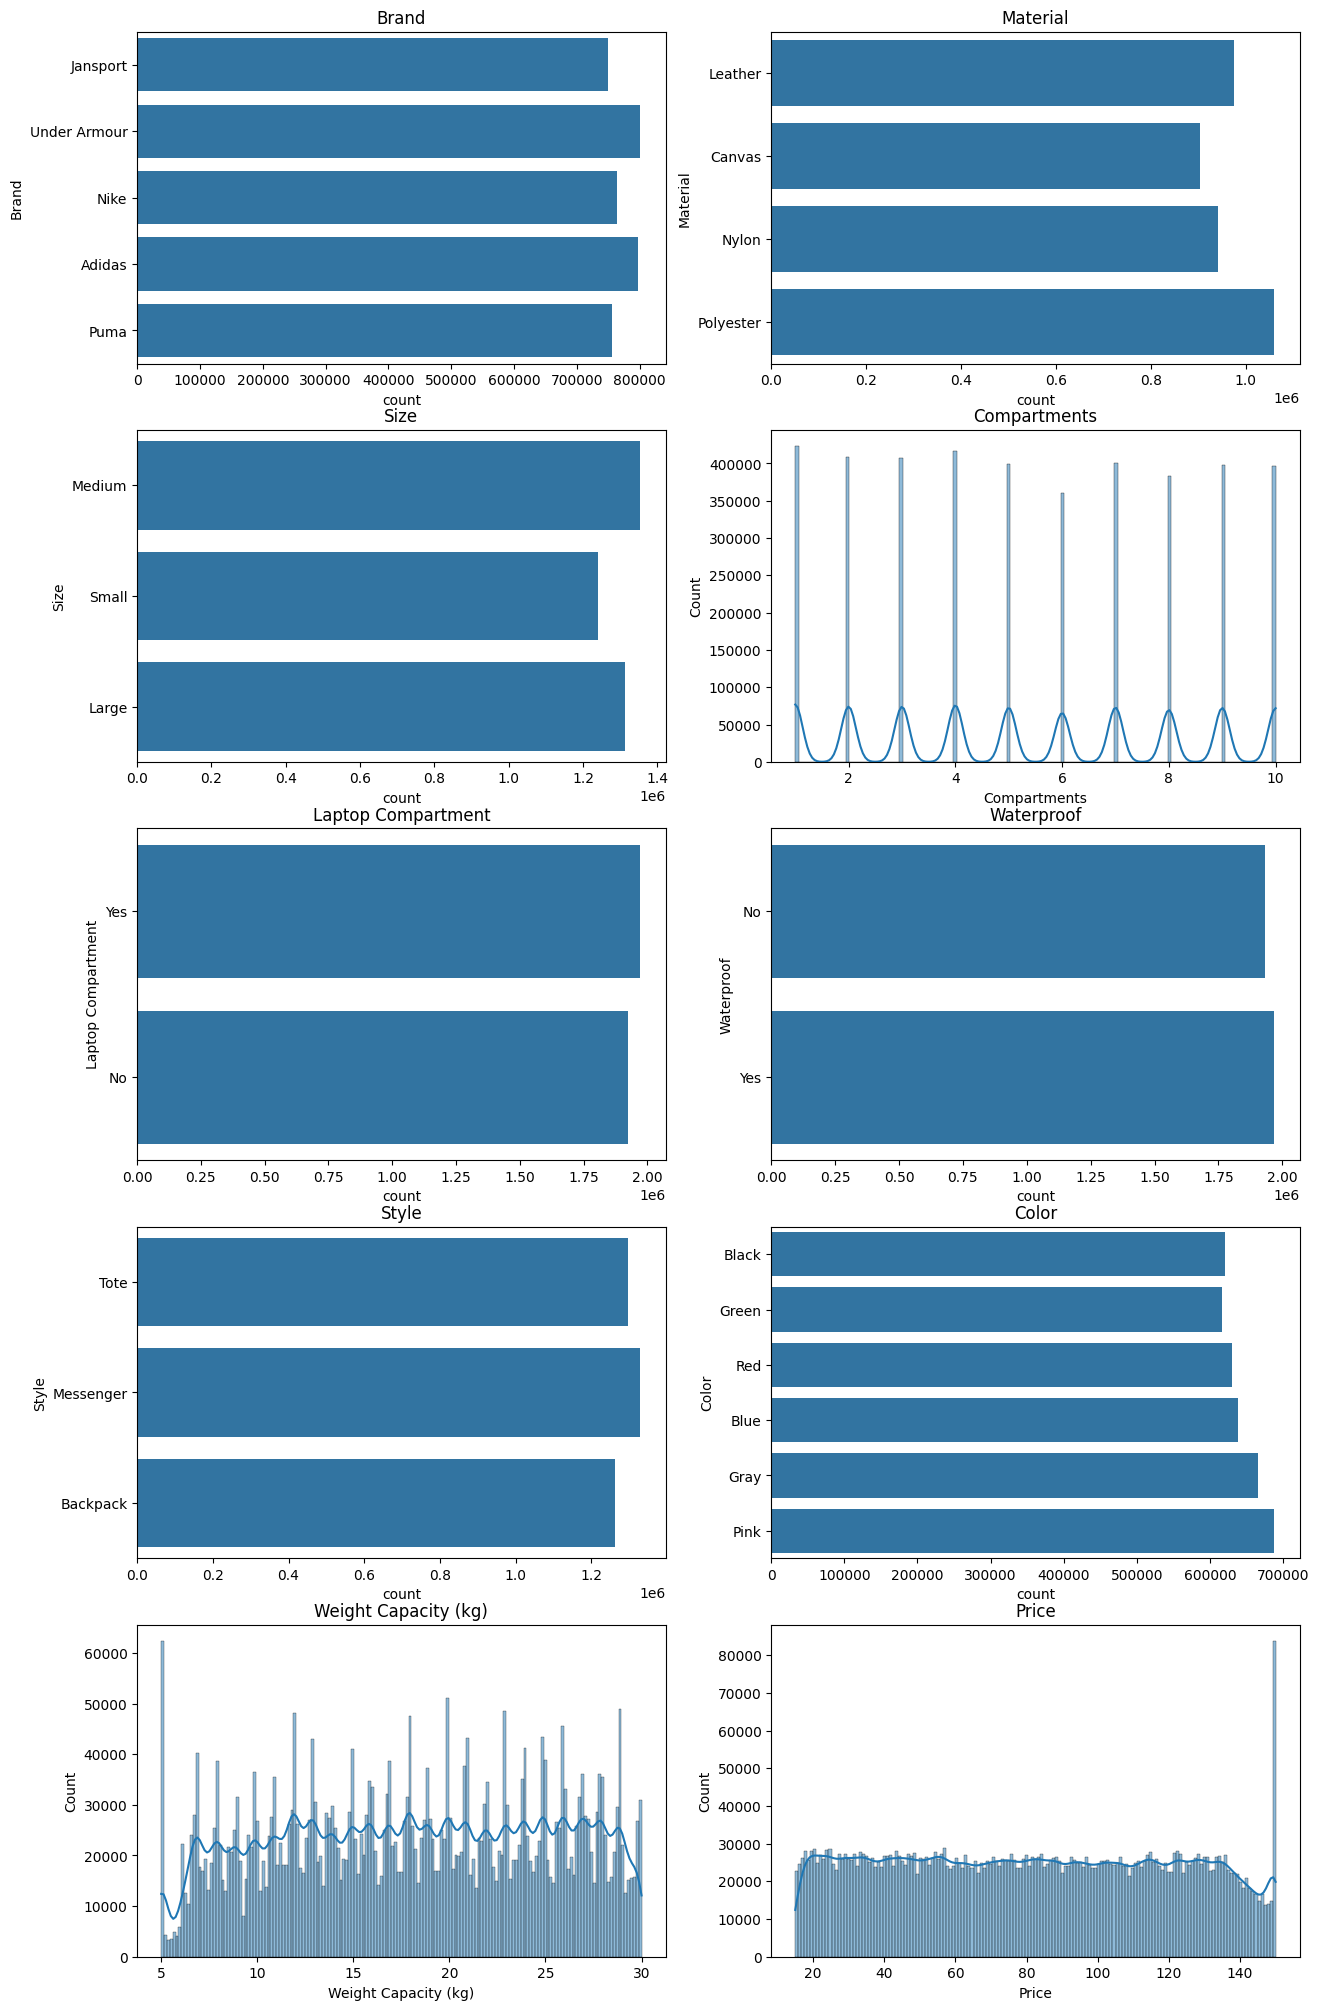

In [13]:
plt.subplots(5, 2, figsize=(15, 25))

for i, col in enumerate(df.columns[1:]):
  plt.subplot(5, 2, i+1)
  plt.title(col)

  if df[col].dtype == 'int64' or df[col].dtype == 'float64':
    sns.histplot(df[col], kde=True)

  else:
    sns.countplot(df[col])

plt.show()

In [14]:
df.groupby(['Brand'])['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Brand,,,,,,,,
Adidas,797000.0,80.527683,38.705181,15.0,46.766860,80.07420,113.59344,150.0
Jansport,749340.0,81.777549,38.847765,15.0,48.158710,81.42694,115.13040,150.0
Nike,764407.0,81.284804,38.900310,15.0,47.287350,80.89513,114.60134,150.0
Puma,755778.0,81.225577,39.149583,15.0,47.178820,80.37190,114.97656,150.0
Under Armour,801035.0,82.065208,38.947707,15.0,48.194915,82.21204,115.89464,150.0


In [ ]:
df.groupby(['Material'])['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Material,,,,,,,,
Canvas,903632.0,81.831022,38.906371,15.0,48.33810,81.71749,115.11291,150.0
Leather,976186.0,80.488749,38.900303,15.0,46.74364,79.36954,114.05714,150.0
Nylon,942656.0,81.071794,38.845618,15.0,47.28735,80.55373,114.56557,150.0
Polyester,1060882.0,82.029424,39.013768,15.0,47.74411,82.05718,115.68017,150.0


In [ ]:
df.groupby(['Style'])['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Style,,,,,,,,
Backpack,1262519.0,81.357717,38.922556,15.0,47.68051,80.74818,114.90182,150.0
Messenger,1329677.0,81.185531,38.807942,15.0,47.47580,80.93027,114.36709,150.0
Tote,1297942.0,81.500007,39.041428,15.0,47.30359,81.19053,115.28515,150.0


In [ ]:
df.groupby(['Color'])['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Color,,,,,,,,
Black,620610.0,80.326088,39.050068,15.0,46.14166,79.23282,114.06052,150.0
Blue,638485.0,82.013390,38.814955,15.0,48.48236,82.35083,115.28953,150.0
Gray,666110.0,80.917014,38.639521,15.0,47.65706,80.01996,114.25760,150.0
Green,617024.0,82.252359,38.805116,15.0,48.66656,82.36755,115.49633,150.0
Pink,688257.0,81.596170,39.064162,15.0,47.33769,81.28464,115.28134,150.0
Red,630215.0,81.010017,39.197671,15.0,46.60277,80.83398,114.70295,150.0


In [ ]:
df.groupby(['Compartments'])['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Compartments,,,,,,,,
1.0,423577.0,81.032016,38.685334,15.0,47.551360,80.45668,114.321680,150.0
2.0,408150.0,81.616355,38.798656,15.0,47.891090,81.42970,115.085360,150.0
3.0,406796.0,81.166371,38.971332,15.0,47.071690,80.74813,114.600640,150.0
4.0,417246.0,81.573869,38.930362,15.0,47.872870,81.62718,115.248210,150.0
5.0,399418.0,81.474432,38.787219,15.0,47.788940,81.36838,114.367090,150.0
6.0,360640.0,81.642001,39.220263,15.0,47.303590,81.49614,115.406430,150.0
7.0,400824.0,81.601284,38.723387,15.0,47.968297,81.30630,115.084800,150.0
8.0,383172.0,81.730636,39.186052,15.0,47.567970,81.34324,115.805630,150.0
9.0,398192.0,80.280526,39.244105,15.0,45.983300,78.89028,114.243597,150.0


In [ ]:
df.groupby(['Size'])['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Size,,,,,,,,
Large,1312295.0,81.611747,39.257066,15.0,47.17882,81.36799,115.55838,150.0
Medium,1354487.0,81.201377,38.594907,15.0,47.76868,80.83802,114.46705,150.0
Small,1239751.0,81.467620,38.886324,15.0,47.80518,81.05931,114.72460,150.0


In [ ]:
df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [15]:

First_Encoder = ColumnTransformer(
    transformers=[
        ('Ordinal Encoder',
         OrdinalEncoder(categories=[
             ['Adidas', 'Under Armour', 'Nike', 'Puma', 'Jansport'],
             ['Polyester', 'Leather', 'Nylon', 'Canvas'],
             ['Small', 'Medium', 'Large'],
             ['No', 'Yes'],
             ['No', 'Yes'],
             ['Messenger', 'Tote', 'Backpack'],
             ['Pink', 'Gray', 'Blue', 'Red', 'Green', 'Black']
         ], handle_unknown='use_encoded_value', unknown_value=np.nan),
         ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
        )
    ], remainder='passthrough'
)

Imputer = ColumnTransformer(
    transformers=[
        ('KNN Imputer', KNNImputer(n_neighbors=5), ['Ordinal Encoder__Brand', 'Ordinal Encoder__Material', 'Ordinal Encoder__Size', 'Ordinal Encoder__Laptop Compartment', 'Ordinal Encoder__Waterproof', 'Ordinal Encoder__Style', 'Ordinal Encoder__Color']),
        ('Simple Imputer', SimpleImputer(strategy='mean'), ['remainder__Weight Capacity (kg)'])
    ], remainder='passthrough'
)


Second_Encoder_Scaler = ColumnTransformer(
    transformers=[
        ('One Hot Encoder', OneHotEncoder(drop='first'), ['Ordinal Encoder__Brand', 'Ordinal Encoder__Material', 'Ordinal Encoder__Style', 'Ordinal Encoder__Color']),
        ('Standard Scaler', StandardScaler(), ['remainder__Weight Capacity (kg)' ])
    ], remainder='passthrough'
)



In [ ]:
First_Encoded_df = First_Encoder.fit_transform(df.drop(columns=['id', 'Price']))
First_Encoded_test_df = First_Encoder.transform(test_df.drop(columns=['id']))
First_Encoded_df = pd.DataFrame(First_Encoded_df, columns=First_Encoder.get_feature_names_out())
First_Encoded_test_df = pd.DataFrame(First_Encoded_test_df, columns=First_Encoder.get_feature_names_out())

In [ ]:
Imputed_df = Imputer.fit_transform(First_Encoded_df)
Imputed_test_df = Imputer.transform(First_Encoded_test_df)
Imputed_df = pd.DataFrame(Imputed_df, columns=Imputer.get_feature_names_out())
Imputed_test_df = pd.DataFrame(Imputed_test_df, columns=Imputer.get_feature_names_out())

In [ ]:
transformed_df = Second_Encoder_Scaler.fit_transform(First_Encoded_df)
transformed_test_df = Second_Encoder_Scaler.transform(First_Encoded_test_df)
transformed_df = pd.DataFrame(transformed_df, columns=Second_Encoder_Scaler.get_feature_names_out())
transformed_test_df = pd.DataFrame(transformed_test_df, columns=Second_Encoder_Scaler.get_feature_names_out())

In [ ]:
X, y = transformed_df, df['Price']
X_eval = transformed_test_df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df, df['Price'], test_size=0.2, random_state=42)

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7f7f18b4f410>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


XGBoostError: [10:44:42] /workspace/src/common/quantile.h:770: Check failed: count <= total_entries (3195454 vs. 0) : 
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7f7f1da5c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x38100f) [0x7f7f1db8100f]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x38149e) [0x7f7f1db8149e]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x54607f) [0x7f7f1dd4607f]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x54a7d2) [0x7f7f1dd4a7d2]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x54b99c) [0x7f7f1dd4b99c]
  [bt] (6) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4fb3ea) [0x7f7f1dcfb3ea]
  [bt] (7) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x18c) [0x7f7f1d973a5c]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f7f8355de2e]



In [ ]:
def xgb_evaluation(max_depth, learning_rate, n_estimators, gamma):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'task_type':'GPU'
    }
    model = XGBRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return np.mean(scores)

pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.1),
    'n_estimators': (50, 200),
    'gamma': (0, 1)
}

optimizer = BayesianOptimization(
    f=xgb_evaluation,
    pbounds=pbounds,
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=25)

print(optimizer.max)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
params = {'gamma': 0.21109223435183444, 'learning_rate': 0.02925390224707257, 'max_depth': 3, 'n_estimators': 168}

xgb_model = XGBRegressor(**params)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

38.90497643984209

In [ ]:
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.21109223435183444, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02925390224707257,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=168, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
logging.getLogger('lightgbm').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found whitespace in feature_names.*")

def lgb_evaluate(num_leaves, max_depth, learning_rate, n_estimators):
    params = {
        'metric': 'rmse',
        'n_estimators': int(n_estimators),
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'verbose': -1,
    }

    # Train the model
    model = lgb.LGBMRegressor(**params)

    # Predict and evaluate
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    return accuracy

# Set up the bounds for each hyperparameter
pbounds = {
    'n_estimators': (20, 200),  # Example range for n_estimators
    'num_leaves': (20, 200),  # Example range for num_leaves
    'max_depth': (5, 50),      # Example range for max_depth
    'learning_rate': (0.01, 0.5) # Example range for learning_rate
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lgb_evaluate,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=35)

# Print the best result found by Bayesian Optimization
print(optimizer.max)

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
| 1         | -38.9     | 0.1935    | 47.78     | 151.8     | 127.8     |
| 2         | -38.88    | 0.08645   | 12.02     | 30.46     | 175.9     |
| 3         | -38.89    | 0.3045    | 36.86     | 23.71     | 194.6     |
| 4         | -38.89    | 0.4179    | 14.56     | 52.73     | 53.01     |
| 5         | -38.88    | 0.1591    | 28.61     | 97.75     | 72.42     |
| 6         | -38.93    | 0.4941    | 27.96     | 96.89     | 71.61     |
| 7         | -38.89    | 0.03412   | 5.832     | 128.1     | 150.3     |


In [ ]:
params = {'learning_rate': 0.03665069827435809, 'max_depth': 24, 'n_estimators': 197, 'num_leaves': 113}

In [ ]:
params =  {'learning_rate': 0.05001022463583663, 'max_depth': 5, 'n_estimators': 27, 'num_leaves': 123}

In [ ]:
X, y = transformed_df, df['Price']

In [ ]:
X_test = transformed_test_df

In [ ]:
model = lgb.LGBMRegressor(**params)
model.fit(X, y)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.276777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 3994318, number of used features: 24
[LightGBM] [Info] Start training from score 81.362175


LGBMRegressor(learning_rate=0.03665069827435809, max_depth=24, n_estimators=197,
              num_leaves=113)

In [ ]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [ ]:
def ctb_evaluate(num_leaves, max_depth, learning_rate, n_estimators):
    params = {
        'metric': 'rmse',
        'n_estimators': int(n_estimators),
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'verbose': -1,
    }

    # Train the model
    model = lgb.LGBMRegressor(**params)

    # Predict and evaluate
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    return accuracy

# Set up the bounds for each hyperparameter
pbounds = {
    'n_estimators': (20, 150),  # Example range for n_estimators
    'border'
    'max_depth': (3, 16),      # Example range for max_depth
    'learning_rate': (0.05, 0.75) # Example range for learning_rate
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lgb_evaluate,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best result found by Bayesian Optimization
print(optimizer.max)

In [ ]:
! pip install catboost
from catboost import CatBoostRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [ ]:
def catboost_cv(learning_rate, depth, l2_leaf_reg):
    params = {
        'learning_rate': learning_rate,
        'depth': int(depth),  # Depth must be an integer
        'l2_leaf_reg': l2_leaf_reg,
        'iterations': 1000,  # Fixed number of iterations
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': 0,
        'task_type':'GPU'
    }

    model = CatBoostRegressor(**params)

    # Perform cross-validation and return the negative RMSE (since BO minimizes the function)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return np.mean(scores)

# Define the Search Space for Bayesian Optimization
param_bounds = {
    'learning_rate': (0.01, 0.3),
    'depth': (4, 10),  # Integer values
    'l2_leaf_reg': (1, 10)
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(f=catboost_cv, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=20)  # 5 initial random points, then 20 BO iterations

# Best Parameters Found
print("Best Parameters:", optimizer.max)

|   iter    |  target   |   depth   | l2_lea... | learni... |
-------------------------------------------------------------
| 1         | -38.9     | 6.247     | 9.556     | 0.2223    |
| 2         | -38.88    | 7.592     | 2.404     | 0.05524   |
| 3         | -38.88    | 4.349     | 8.796     | 0.1843    |
| 4         | -39.0     | 8.248     | 1.185     | 0.2913    |
| 5         | -38.89    | 8.995     | 2.911     | 0.06273   |
| 6         | -38.88    | 4.294     | 8.864     | 0.2441    |
| 7         | -38.9     | 7.614     | 3.538     | 0.1235    |
| 8         | -38.88    | 6.306     | 2.708     | 0.05188   |
| 9         | -38.88    | 4.114     | 7.291     | 0.2413    |
| 10        | -38.89    | 5.549     | 7.653     | 0.2794    |
| 11        | -38.88    | 4.784     | 5.811     | 0.0897    |
| 12        | -38.88    | 5.257     | 4.251     | 0.05575   |
| 13        | -38.89    | 6.21      | 5.466     | 0.196     |
| 14        | -38.88    | 4.802     | 2.804     | 0.0593    |
| 15    

In [ ]:
cat_params = {'iterations': 2500, 'depth': 6, 'l2_leaf_reg': 2.7077429266423243, 'learning_rate': 0.051879077487633055, 'verbose':100, 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'task_type':'GPU'}

In [ ]:
model = CatBoostRegressor(**cat_params)
model.fit(X, y)

0:	learn: 38.9357493	total: 42.1ms	remaining: 1m 45s
100:	learn: 38.8884899	total: 3.04s	remaining: 1m 12s
200:	learn: 38.8789711	total: 6s	remaining: 1m 8s
300:	learn: 38.8730922	total: 9s	remaining: 1m 5s
400:	learn: 38.8679989	total: 14s	remaining: 1m 13s
500:	learn: 38.8638170	total: 16.9s	remaining: 1m 7s
600:	learn: 38.8603999	total: 19.9s	remaining: 1m 2s
700:	learn: 38.8572793	total: 22.9s	remaining: 58.8s
800:	learn: 38.8543053	total: 27.7s	remaining: 58.8s
900:	learn: 38.8516297	total: 30.8s	remaining: 54.6s
1000:	learn: 38.8489242	total: 33.8s	remaining: 50.6s
1100:	learn: 38.8464050	total: 37.2s	remaining: 47.2s
1200:	learn: 38.8440275	total: 41.6s	remaining: 45s
1300:	learn: 38.8417950	total: 44.6s	remaining: 41.1s
1400:	learn: 38.8396086	total: 49.3s	remaining: 38.7s
1500:	learn: 38.8374832	total: 56.8s	remaining: 37.8s
1600:	learn: 38.8353510	total: 59.8s	remaining: 33.6s
1700:	learn: 38.8333970	total: 1m 2s	remaining: 29.5s
1800:	learn: 38.8314197	total: 1m 8s	remaining

In [ ]:
pd.DataFrame({'id': test_df['id'], 'Price': model.predict(X_eval)}).to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c playground-series-s5e2 -f submission.csv -m "CatBoostRegressor(max_depth=5, learning_rate=0.033163999000637275, l2_leaf_reg= 9.182247292936465, loss_function='RMSE', eval_metric='RMSE', verbose=0)"

100% 4.74M/4.74M [00:01<00:00, 4.57MB/s]
Successfully submitted to Backpack Prediction Challenge